<a href="https://colab.research.google.com/github/ValeriiYermak/DataScience/blob/main/HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Налаштування параметрів моделі
num_classes = 10
num_features = 784
learning_rate = 0.001
training_steps = 3000  # Збільшуємо кількість епох
batch_size = 256
display_step = 100
n_hidden_1 = 128  # Збільшуємо кількість нейронів у шарах
n_hidden_2 = 256

# Завантаження та підготовка даних
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]) / 255.0, x_test.reshape([-1, num_features]) / 255.0

# Перетворення міток на тип int64
y_train, y_test = np.array(y_train, np.int64), np.array(y_test, np.int64)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(5000).batch(batch_size).prefetch(1)

# Визначення класів для нейронної мережі
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, activation=tf.nn.relu, dropout_rate=0.0, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.keras.initializers.GlorotUniform()(shape=[in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.activation = activation
        self.dropout_rate = dropout_rate

    def __call__(self, x, training=False):
        y = tf.matmul(x, self.w) + self.b
        y = self.activation(y)
        if training and self.dropout_rate > 0:
            y = tf.nn.dropout(y, rate=self.dropout_rate)
        return y

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer_1 = DenseLayer(num_features, n_hidden_1, dropout_rate=0.2)
        self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2, dropout_rate=0.2)
        self.layer_3 = DenseLayer(n_hidden_2, num_classes, activation=tf.nn.softmax)

    def __call__(self, x, training=False):
        x = self.layer_1(x, training=training)
        x = self.layer_2(x, training=training)
        return self.layer_3(x)

# Визначення функцій для обчислення втрат та точності
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def cross_entropy(y_pred, y_true):
    return loss_object(y_true, y_pred)

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, axis=1), y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Створення нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
optimizer = tf.optimizers.Adam(learning_rate)  # Використання оптимізатора Adam

@tf.function
def train_step(nn, input_x, output_y):
    with tf.GradientTape() as tape:
        predictions = nn(input_x, training=True)
        loss = cross_entropy(predictions, output_y)
    gradients = tape.gradient(loss, nn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, nn.trainable_variables))
    return loss, accuracy(predictions, output_y)

# Тренування нейронної мережі
loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    loss, acc = train_step(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())
        print(f"Step: {step}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Step: 0, Loss: 2.3311, Accuracy: 0.0859
Step: 100, Loss: 0.3353, Accuracy: 0.8945
Step: 200, Loss: 0.1625, Accuracy: 0.9492
Step: 300, Loss: 0.1787, Accuracy: 0.9453
Step: 400, Loss: 0.1755, Accuracy: 0.9492
Step: 500, Loss: 0.1837, Accuracy: 0.9492
Step: 600, Loss: 0.0961, Accuracy: 0.9727
Step: 700, Loss: 0.1740, Accuracy: 0.9531
Step: 800, Loss: 0.1174, Accuracy: 0.9570
Step: 900, Loss: 0.1693, Accuracy: 0.9531
Step: 1000, Loss: 0.0757, Accuracy: 0.9805
Step: 1100, Loss: 0.1235, Accuracy: 0.9805
Step: 1200, Loss: 0.0488, Accuracy: 0.9883
Step: 1300, Loss: 0.0691, Accuracy: 0.9727
Step: 1400, Loss: 0.0804, Accuracy: 0.9727
Step: 1500, Loss: 0.0835, Accuracy: 0.9727
Step: 1600, Loss: 0.0643, Accuracy: 0.9844
Step: 1700, Loss: 0.0455, Accuracy: 0.9922
Step: 1800, Loss: 0.0734, Accuracy: 0.9766
Step: 1900, Loss: 0.0728, Accuracy: 0.9727
Step: 2000, Loss: 0.0644, Accuracy: 0.9727
Step: 2100, Loss: 0.0184, Accuracy: 0.9961
Step: 2200, Loss: 0.0333, Accuracy: 0.9922
Step: 2300, Loss: 0.050

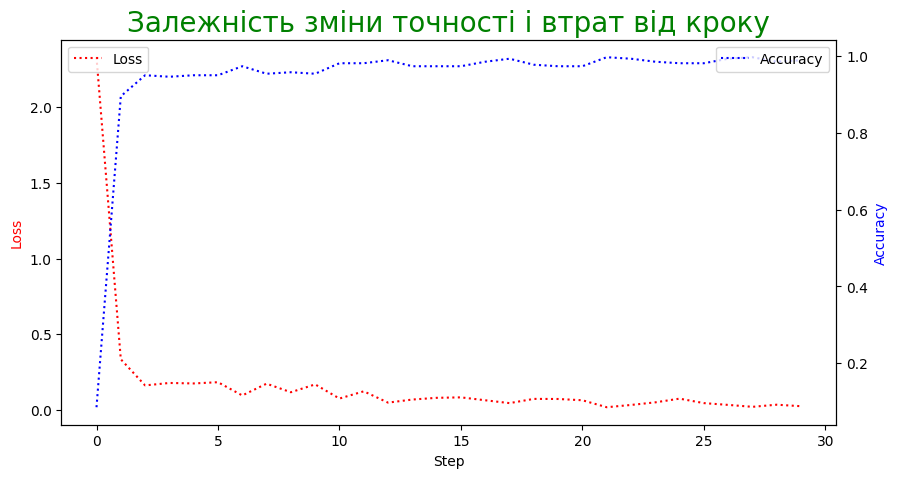

In [21]:
# Побудова графіків
fig, axs = plt.subplots(figsize=(10, 5))
axs.plot(loss_history, 'r', label='Loss', linestyle=":")
axs.set_xlabel('Step')
axs.set_ylabel('Loss', color='r')
axs.legend(loc='upper left')

axs2 = axs.twinx()
axs2.plot(accuracy_history, 'b', label='Accuracy', linestyle=":")
axs2.set_ylabel('Accuracy', color='b')
axs2.legend(loc='upper right')

plt.title('Залежність зміни точності і втрат від кроку', fontsize=20, color='g')
plt.show()


In [17]:
# Обчислення точності навченої нейромережі на тренувальних даних
train_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")

Train Accuracy: 0.9948


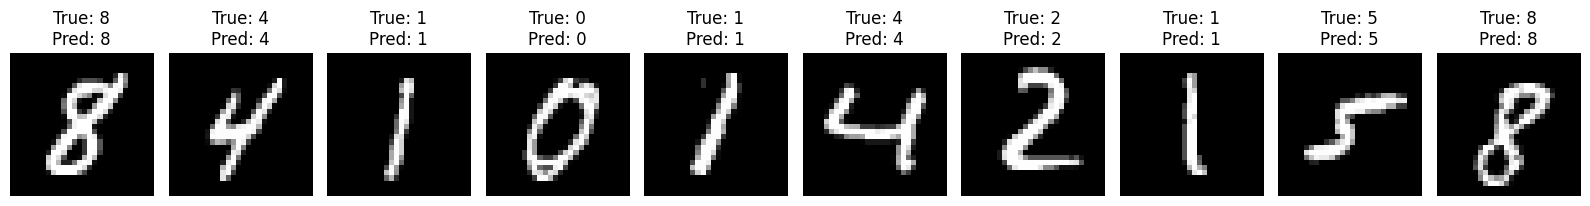

In [18]:

# Тестування нейронної мережі на тестових зображеннях
test_imgs = np.random.choice(x_test.shape[0], 10, replace=False)
predictions = tf.argmax(neural_net(x_test[test_imgs]), axis=1).numpy()

plt.figure(figsize=(16, 6))
for i, img_idx in enumerate(test_imgs):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[img_idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_test[img_idx]}\nPred: {predictions[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


**ВИСНОВКИ**


Ці результати показують, що після внесення змін до коду, модель демонструє значно кращу продуктивність на тренувальних даних.

На початкових кроках (Step: 0) модель має високу втрату (Loss: 2.3311) і низьку точність (Accuracy: 0.0859), що є очікуваним, оскільки модель ще не навчена.
Після декількох сотень кроків (наприклад, Step: 100, Loss: 0.3353, Accuracy: 0.8945), втрати значно зменшуються, а точність значно збільшується. Це означає, що модель успішно навчається.
В кінці тренування (наприклад, Step: 2900, Loss: 0.0250, Accuracy: 0.9883) втрати дуже малі, а точність майже досягає 99%, що свідчить про високу якість навчання моделі.
Про що говорить даний результат:

Висока точність (Accuracy):

Модель дуже добре розпізнає зображення цифр з MNIST на тренувальних даних. Висока точність близько 99% означає, що модель правильно класифікує майже всі зображення в наборі даних.
Низькі втрати (Loss):

Низька функція втрат показує, що модель успішно мінімізувала помилки під час навчання, що також підтверджується високою точністю.